In [1]:
# Imports
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
# Upload cleaned csvs to Colab
from google.colab import files

csv_file = files.upload()

Saving bos_housing_prices.csv to bos_housing_prices.csv
Saving chi_housing_prices.csv to chi_housing_prices.csv
Saving clean_interest_rates.csv to clean_interest_rates.csv
Saving hou_housing_prices.csv to hou_housing_prices.csv
Saving lax_housing_prices.csv to lax_housing_prices.csv
Saving MHI_interpolated.csv to MHI_interpolated.csv
Saving mia_housing_prices.csv to mia_housing_prices.csv
Saving nyc_housing_prices.csv to nyc_housing_prices.csv
Saving pho_housing_prices.csv to pho_housing_prices.csv
Saving sea_housing_prices.csv to sea_housing_prices.csv
Saving unemployment_cleaned.csv to unemployment_cleaned.csv
Saving vix_lumber_spy.csv to vix_lumber_spy.csv


In [3]:
#read cleaned csvs into dataframes
vix_lumber_spy_df = pd.read_csv('vix_lumber_spy.csv')
lax_df = pd.read_csv('lax_housing_prices.csv')
MHI_df = pd.read_csv('MHI_interpolated.csv')
mia_df = pd.read_csv('mia_housing_prices.csv')
nyc_df = pd.read_csv('nyc_housing_prices.csv')
pho_df = pd.read_csv('pho_housing_prices.csv')
sea_df = pd.read_csv('sea_housing_prices.csv')
unemployment_df = pd.read_csv('unemployment_cleaned.csv')
hou_df = pd.read_csv('hou_housing_prices.csv')
rates_df = pd.read_csv('clean_interest_rates.csv')
chi_df = pd.read_csv('chi_housing_prices.csv')
bos_df = pd.read_csv('bos_housing_prices.csv')

In [4]:
#rename DATE and index columns to Date
MHI_df = MHI_df.rename(columns={'index': 'Date'})
rates_df = rates_df.rename(columns={'DATE': 'Date'})
unemployment_df = unemployment_df.rename(columns={'DATE': 'Date'})
vix_lumber_spy_df = vix_lumber_spy_df.rename(columns={'index': 'Date'})

In [5]:
#specify the list of dataframes to be merged
dataframes = [vix_lumber_spy_df, lax_df, MHI_df, mia_df, nyc_df, pho_df, sea_df, unemployment_df, hou_df, rates_df, chi_df, bos_df]

#merge the dataframes using the 'outer' join method
cribpredict_df = dataframes[0]

#iterate over the remaining dataframes and merge them with the 'left'
for df in dataframes[1:]:
    cribpredict_df = pd.merge(cribpredict_df, df, on=['Date'], how='outer')

#display the merged dataframe
cribpredict_df.tail()


,Date,VIX,Lumber,SPY,Los Angeles,MIA_MHI,BOS_MHI,PHO_MHI,NY_MHI,SEA_MHI,...,NY_UR,SEA_UR,LA_UR,HOU_UR,CHI_UR,Houston,DFF,MORTGAGE30US,Chicago,Boston
398,1996-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.2,4.5,6.9,5.4,4.9,NaN,NaN,NaN,NaN,NaN
399,1996-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.2,4.3,6.9,5.0,4.7,NaN,NaN,NaN,NaN,NaN
400,1996-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.3,4.4,6.8,5.4,4.6,NaN,NaN,NaN,NaN,NaN
401,1996-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.3,4.1,6.7,5.2,4.9,NaN,NaN,NaN,NaN,NaN
402,1996-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.3,4.6,6.7,5.9,5.7,NaN,NaN,NaN,NaN,NaN


In [6]:
#check data types
cribpredict_df.dtypes

Date             object
VIX             float64
Lumber          float64
SPY             float64
Los Angeles     float64
MIA_MHI         float64
BOS_MHI         float64
PHO_MHI         float64
NY_MHI          float64
SEA_MHI         float64
LA_MHI          float64
HOU_MHI         float64
CHI_MHI         float64
Miami           float64
New York        float64
Phoenix         float64
Seattle         float64
MIA_UR          float64
BOS_UR          float64
PHO_UR          float64
NY_UR           float64
SEA_UR          float64
LA_UR           float64
HOU_UR          float64
CHI_UR          float64
Houston         float64
DFF             float64
MORTGAGE30US    float64
Chicago         float64
Boston          float64
dtype: object

In [7]:
cribpredict_df['Date'] = pd.to_datetime(cribpredict_df['Date'])
cribpredict_df.set_index('Date', inplace=True)
cribpredict_df

,VIX,Lumber,SPY,Los Angeles,MIA_MHI,BOS_MHI,PHO_MHI,NY_MHI,SEA_MHI,LA_MHI,...,NY_UR,SEA_UR,LA_UR,HOU_UR,CHI_UR,Houston,DFF,MORTGAGE30US,Chicago,Boston
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-01,22.718261,333.900000,150.375000,NaN,33055.666667,29118.833333,33255.583333,31067.208333,39642.50,32362.750,...,4.1,3.8,5.1,4.1,4.2,NaN,5.853548,8.2400,NaN,NaN
2000-04-01,27.098500,311.249474,146.231911,NaN,32969.500000,29221.250000,33321.625000,31156.687500,39711.25,32395.375,...,4.3,4.1,5.1,4.4,4.2,NaN,6.019667,8.1525,NaN,NaN
2000-05-01,26.290435,291.777273,142.080250,NaN,32883.333333,29323.666667,33387.666667,31246.166667,39780.00,32428.000,...,4.2,4.3,5.0,4.7,4.7,NaN,6.268065,8.5150,NaN,NaN
2000-06-01,21.540000,288.352727,146.521318,NaN,32797.166667,29426.083333,33453.708333,31335.645833,39848.75,32460.625,...,4.6,4.4,5.0,4.6,4.6,NaN,6.528333,8.2880,NaN,NaN
2000-07-01,19.890000,258.655000,147.503905,NaN,32711.000000,29528.500000,33519.750000,31425.125000,39917.50,32493.250,...,4.5,4.4,4.9,4.6,4.3,NaN,6.544516,8.1475,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.2,4.5,6.9,5.4,4.9,NaN,NaN,NaN,NaN,NaN
1996-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.2,4.3,6.9,5.0,4.7,NaN,NaN,NaN,NaN,NaN
1996-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.3,4.4,6.8,5.4,4.6,NaN,NaN,NaN,NaN,NaN


In [8]:
###WILL STUFF
temp = cribpredict_df.copy().dropna()

In [9]:
#helper functions

#handles separating out by city
def prep_df(df, name, abbreviation):
  cribpredict_df = df.copy().dropna()
  city_df = cribpredict_df[['VIX', 'Lumber', 'SPY',name,f'{abbreviation}_MHI','DFF','MORTGAGE30US',f'{abbreviation}_UR']]
  return city_df

#handles the splitting of data set (respecting time series nature of data)
def process_df(df, city_name):
  df[city_name] = df[city_name].shift(3)
  df = df.dropna()
  n = len(df)
  train_df = df[0:int(n*0.7)]
  test_df = df[int(n*0.7):int(n)]
  train_features = train_df.copy()
  test_features = test_df.copy()

  train_labels = train_features.pop(city_name)
  test_labels = test_features.pop(city_name)
  return train_features, test_features, train_labels, test_labels

In [67]:
HOU_df = prep_df(cribpredict_df, 'Houston', 'HOU')
CHI_df = prep_df(cribpredict_df, 'Chicago', 'CHI')
NYC_df = prep_df(cribpredict_df, 'New York', 'NY')
SEA_df = prep_df(cribpredict_df, 'Seattle', 'SEA')
MIA_df = prep_df(cribpredict_df, 'Miami', 'MIA')
PHO_df = prep_df(cribpredict_df, 'Phoenix', 'PHO')
BOS_df = prep_df(cribpredict_df, 'Boston', 'BOS')
LAX_df = prep_df(cribpredict_df, 'Los Angeles', 'LA')

In [11]:
## Scrap attempt... did not work as expected so can ignore next ~17 cells if you would like

In [16]:
n = len(df)
train_df = df[0:int(n*0.7)]
test_df = df[int(n*0.7):int(n)]

In [18]:
train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop('Boston')
test_labels = test_features.pop('Boston')

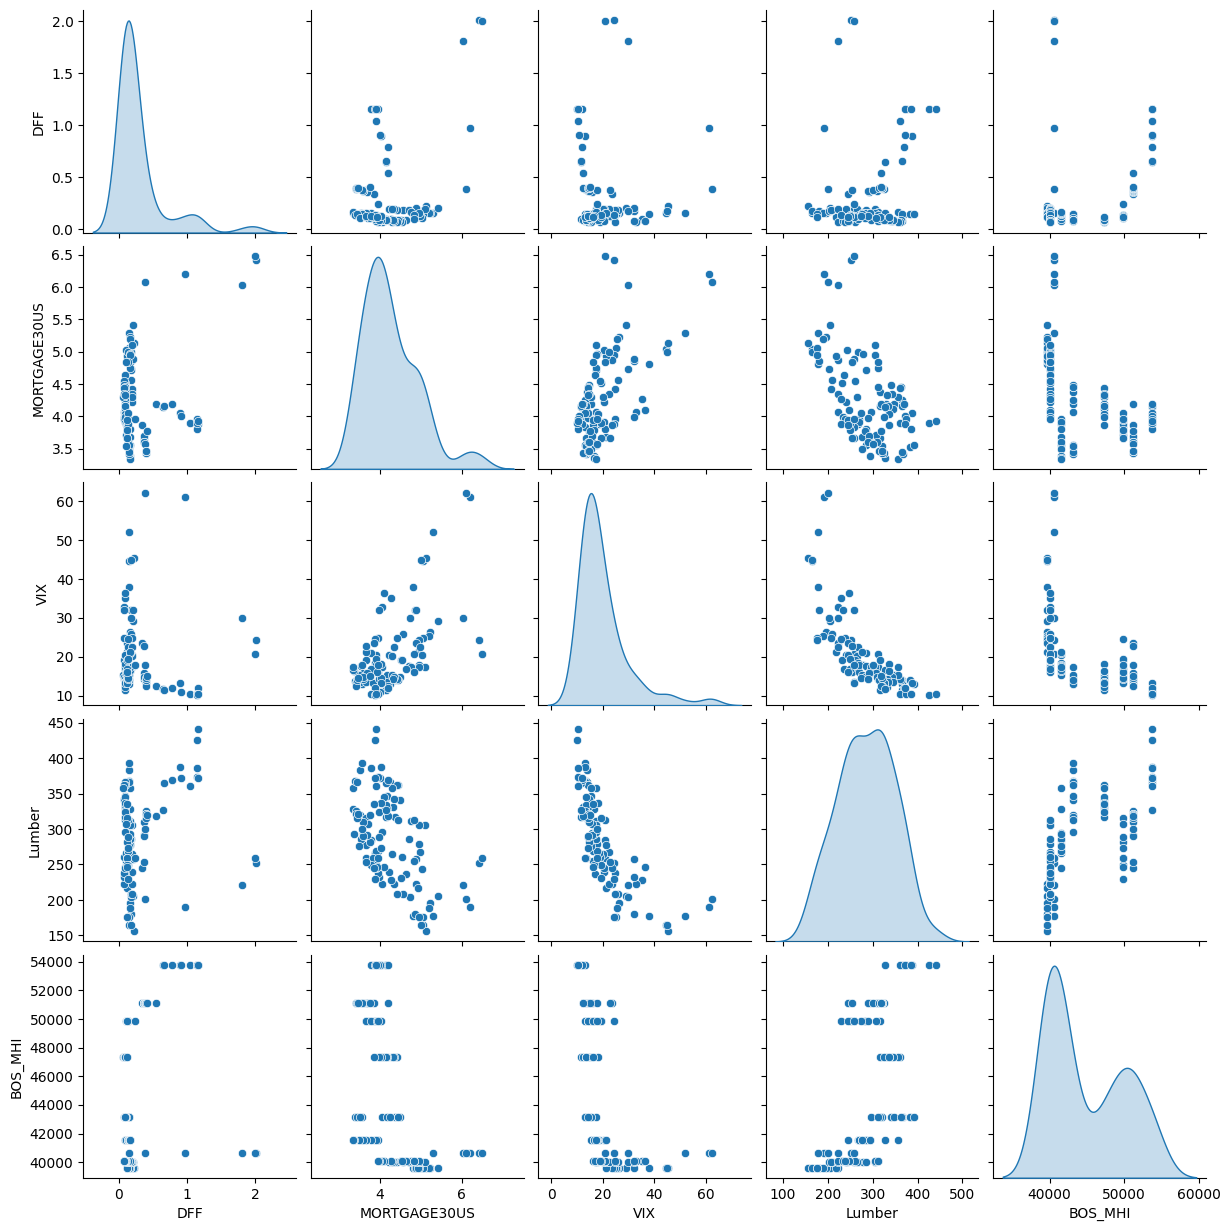

In [19]:
sns.pairplot(train_features[['DFF', 'MORTGAGE30US', 'VIX', 'Lumber','BOS_MHI']], diag_kind='kde')

In [20]:
#illustrate the need to normalize the data
train_df.describe().transpose()[['mean', 'std']]

,mean,std
VIX,19.973283,9.814439
Lumber,285.496403,62.582266
SPY,161.804616,48.394756
Boston,341279.318584,31862.387056
BOS_MHI,44843.601770,5068.636146
DFF,0.297661,0.385919
MORTGAGE30US,4.269013,0.670931
BOS_UR,5.561062,1.472391


In [21]:
#normalize
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [22]:
#show outputs of normalizing
print(normalizer.mean.numpy())

[[1.9973284e+01 2.8549637e+02 1.6180461e+02 4.4843602e+04 2.9766098e-01
  4.2690134e+00 5.5610623e+00]]


In [23]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [24]:
linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 7)                15        
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 8         
                                                                 
Total params: 23
Trainable params: 8
Non-trainable params: 15
_________________________________________________________________


In [25]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(7, 1) dtype=float32, numpy=
array([[-0.35876954],
       [-0.5174519 ],
       [-0.46050152],
       [-0.38366956],
       [-0.00188696],
       [ 0.35409695],
       [-0.66446364]], dtype=float32)>

In [26]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [27]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=500,
    # Suppress logging.
    verbose=0)
    # Calculate validation results on 20% of the training data.
    # validation_split = 0.2)

CPU times: user 4.59 s, sys: 157 ms, total: 4.75 s
Wall time: 4.61 s


In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,epoch
0,341279.25000,0
1,341278.78125,1
2,341278.40625,2
3,341277.96875,3
4,341277.59375,4
...,...,...
495,341081.21875,495
496,341080.78125,496
497,341080.37500,497
498,341080.00000,498


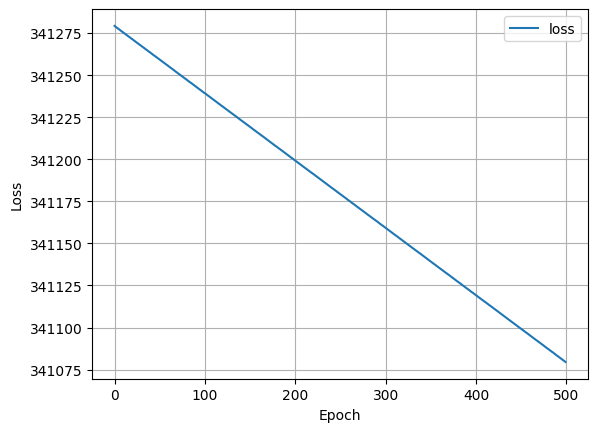

In [29]:
plot_loss(history)

In [30]:
linear_model.evaluate(
    test_features, test_labels, verbose=2)

2/2 - 0s - loss: 469291.7500 - 131ms/epoch - 65ms/step


469291.75

In [31]:
test_results = {}

In [32]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [33]:
test_results

{'linear_model': 469291.75}

In [ ]:
###end of scrap work... the above was a failure and we reverted back to a more straightforward way...

In [33]:
## Start of work we actually ended up showing in presentation

In [33]:
#try using pct change data instead of true values... this leads to significantly worse results
#the cribpredict_df (without rolling and pct change) yields better prediction outcomes in terms of MAPE

In [72]:
temp = cribpredict_df.copy().dropna()
targets = temp[['New York','Chicago','Boston','Miami','Los Angeles','Seattle','Houston','Phoenix']]
temp.drop(columns= ['New York','Chicago','Boston','Miami','Los Angeles','Seattle','Houston','Phoenix'], inplace=True)
temp_df_pct = temp.pct_change()
temp_rolling = temp_df_pct.rolling(window=3).mean()
temp_rolling = temp_rolling.dropna()
temp_rolling = temp_rolling.iloc[0:-12,:]
cribpredict_new = pd.concat([temp_rolling, targets], axis=1)
cribpredict_new = cribpredict_new.dropna()
cribpredict_new

,VIX,Lumber,SPY,MIA_MHI,BOS_MHI,PHO_MHI,NY_MHI,SEA_MHI,LA_MHI,HOU_MHI,...,DFF,MORTGAGE30US,New York,Chicago,Boston,Miami,Los Angeles,Seattle,Houston,Phoenix
Date,,,,,,,,,,,,,,,,,,,,,
2008-07-01,0.052239,0.039815,-0.027706,-0.004942,-0.002109,-0.001970,-0.002584,-0.001789,-0.000939,0.004094,...,-0.038628,0.027950,407333.0,248333.0,351000.0,247333.0,480833.0,334817.0,152167.0,221967.0
2008-08-01,0.051806,0.015175,-0.028916,-0.004966,-0.002114,-0.001974,-0.002591,-0.001793,-0.000940,0.004078,...,0.003062,0.023946,414000.0,251667.0,353333.0,250000.0,467500.0,332483.0,153500.0,216633.0
2008-09-01,0.131303,-0.030107,-0.030862,-0.004991,-0.002118,-0.001978,-0.002597,-0.001796,-0.000941,0.004061,...,-0.031600,-0.014380,412333.0,249167.0,339233.0,241633.0,452000.0,326400.0,152467.0,208300.0
2008-10-01,0.447269,-0.085416,-0.078218,-0.005016,-0.002123,-0.001982,-0.002604,-0.001799,-0.000942,0.004045,...,-0.188025,-0.010999,401667.0,240833.0,325900.0,231600.0,440000.0,321900.0,146467.0,203333.0
2008-11-01,0.503228,-0.076260,-0.113661,-0.005041,-0.002127,-0.001986,-0.002611,-0.001802,-0.000943,0.004029,...,-0.385857,-0.019719,387500.0,233083.0,312567.0,218267.0,425000.0,312831.0,138633.0,196667.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,-0.091074,0.284766,0.051256,-0.000499,0.005231,0.001006,0.005706,0.003369,0.002356,0.001986,...,0.257744,-0.031612,441000.0,258967.0,515000.0,318333.0,701333.0,531667.0,256630.0,317833.0
2020-09-01,-0.023553,0.198970,0.027442,-0.000499,0.005204,0.001005,0.005674,0.003358,0.002350,0.001982,...,0.055221,-0.029504,448333.0,262300.0,518333.0,323333.0,719667.0,540750.0,258300.0,324333.0
2020-10-01,0.041684,0.049530,0.021770,-0.000500,0.005177,0.001004,0.005642,0.003346,0.002345,0.001978,...,-0.008788,-0.020522,455000.0,264000.0,513333.0,324333.0,726667.0,545750.0,257467.0,329833.0


In [56]:
#again, you can use cribpredict_new (with rolling / pct change) or cribpredict_df (without)
#the latter performs better
HOU_df = prep_df(cribpredict_new, 'Houston', 'HOU')
CHI_df = prep_df(cribpredict_new, 'Chicago', 'CHI')
NYC_df = prep_df(cribpredict_new, 'New York', 'NY')
SEA_df = prep_df(cribpredict_new, 'Seattle', 'SEA')
MIA_df = prep_df(cribpredict_new, 'Miami', 'MIA')
PHO_df = prep_df(cribpredict_new, 'Phoenix', 'PHO')
BOS_df = prep_df(cribpredict_new, 'Boston', 'BOS')
LAX_df = prep_df(cribpredict_new, 'Los Angeles', 'LA')

In [ ]:
#cribpredict_df data prep process... better results but without pct change / rolling
HOU_df = prep_df(cribpredict_df, 'Houston', 'HOU')
CHI_df = prep_df(cribpredict_df, 'Chicago', 'CHI')
NYC_df = prep_df(cribpredict_df, 'New York', 'NY')
SEA_df = prep_df(cribpredict_df, 'Seattle', 'SEA')
MIA_df = prep_df(cribpredict_df, 'Miami', 'MIA')
PHO_df = prep_df(cribpredict_df, 'Phoenix', 'PHO')
BOS_df = prep_df(cribpredict_df, 'Boston', 'BOS')
LAX_df = prep_df(cribpredict_df, 'Los Angeles', 'LA')

In [57]:
def process_df(df, city_name):
  df[city_name] = df[city_name].shift(3)
  df = df.dropna()
  n = len(df)
  train_df = df[0:int(n*0.7)]
  test_df = df[int(n*0.7):int(n)]
  train_features = train_df.copy()
  test_features = test_df.copy()

  train_labels = train_features.pop(city_name)
  test_labels = test_features.pop(city_name)
  return train_features, test_features, train_labels, test_labels

In [58]:
train_features, test_features, train_labels, test_labels = process_df(CHI_df, 'Chicago')

In [26]:
X_scaler = StandardScaler()

# Fit the scaler
X_scaler.fit(train_features)

# Scale the data
train_features_scaled = X_scaler.transform(train_features)
test_features_scaled = X_scaler.transform(test_features)

In [27]:
linear_model_2 = tf.keras.Sequential()

In [28]:
number_input_features = 7
hidden_nodes_layer1 =  6
hidden_nodes_layer2 =  3

In [29]:
linear_model_2.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))
linear_model_2.add(Dense(units=hidden_nodes_layer2, input_dim=number_input_features, activation="relu"))
linear_model_2.add(Dense(units=1, activation="relu"))

In [30]:
linear_model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error', metrics=['mape'])

In [31]:
model = linear_model_2.fit(train_features_scaled,
    train_labels,
    verbose=0, epochs=100)

<Axes: >

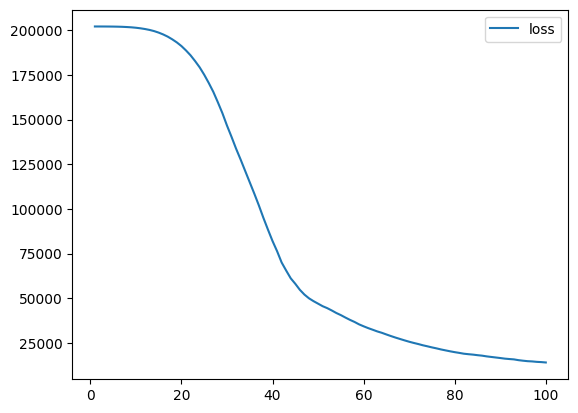

In [32]:
df = pd.DataFrame(model.history, index=range(1, len(model.history["loss"]) + 1))
df.plot(y="loss")

In [33]:
 model_loss, model_mape = linear_model_2.evaluate(test_features_scaled, test_labels, verbose=2)

2/2 - 0s - loss: 41179.9453 - mape: 17.6818 - 103ms/epoch - 51ms/step


2/2 [==============================] - 0s 3ms/step


<Figure size 2500x1000 with 0 Axes>

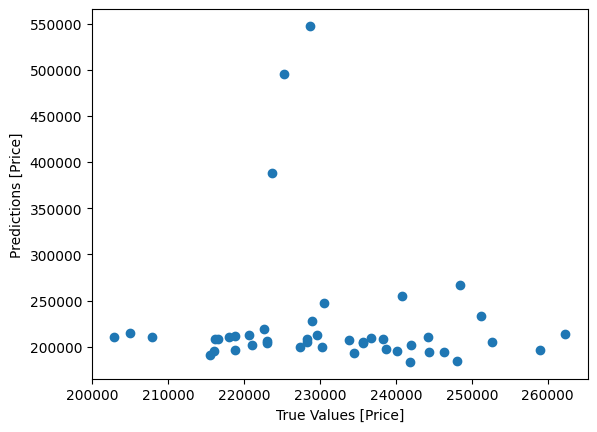

<Figure size 2500x1000 with 0 Axes>

In [34]:
test_predictions = linear_model_2.predict(test_features_scaled).flatten()
# train_predictions = linear_model_2.predict(train_features).flatten()

a = plt.axes(aspect='auto')
plt.scatter(test_labels, test_predictions)
# plt.scatter(train_labels, train_predictions)
plt.xlabel('True Values [Price]')
plt.ylabel('Predictions [Price]')
plt.figure(figsize= (25,10))
# lims = [0, .0]
#plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)

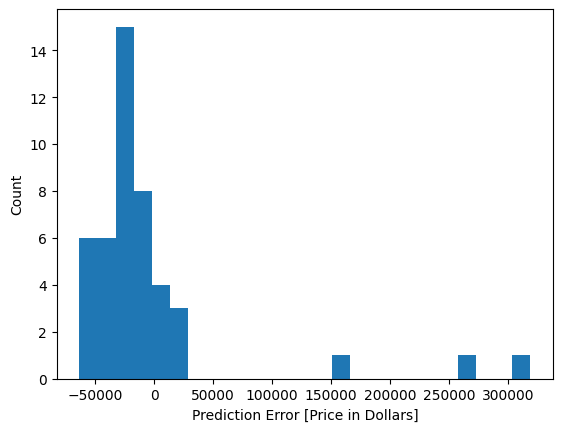

In [35]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Price in Dollars]')
_ = plt.ylabel('Count')


In [36]:
number_input_features = 7
hidden_nodes_layer1 =  4
hidden_nodes_layer2 =  2

In [37]:
linear_model_3 = tf.keras.Sequential()

In [38]:
linear_model_3.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))
linear_model_3.add(Dense(units=hidden_nodes_layer2, input_dim=number_input_features, activation="relu"))
linear_model_3.add(Dense(units=1, activation="relu"))

In [39]:
linear_model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error', metrics=['mape'])

In [40]:
model = linear_model_3.fit(train_features_scaled,
    train_labels,
    verbose=0, epochs=100)

<Axes: >

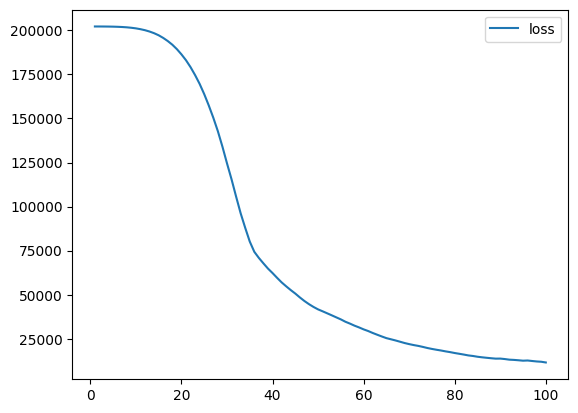

In [41]:
df = pd.DataFrame(model.history, index=range(1, len(model.history["loss"]) + 1))
df.plot(y="loss")

In [42]:
model_loss_3, model_mape_3 = linear_model_3.evaluate(test_features_scaled, test_labels, verbose=2)

2/2 - 0s - loss: 42598.3594 - mape: 18.3077 - 92ms/epoch - 46ms/step


In [61]:
#define two hidden layer neural network where number of nodes is flexible and can be specified
def model_function(df, city, features, layer1, layer2):
  train_features, test_features, train_labels, test_labels = process_df(df, city)
  X_scaler = StandardScaler()

  # scaler
  X_scaler.fit(train_features)
  train_features_scaled = X_scaler.transform(train_features)
  test_features_scaled = X_scaler.transform(test_features)

  number_input_features = features
  hidden_nodes_layer1 =  layer1
  hidden_nodes_layer2 =  layer2
  linear_model_n = tf.keras.Sequential()
  linear_model_n.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))
  linear_model_n.add(Dense(units=hidden_nodes_layer2, input_dim=number_input_features, activation="relu"))
  linear_model_n.add(Dense(units=1, activation="relu"))
  linear_model_n.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error', metrics=['mape'])
  model = linear_model_n.fit(train_features_scaled,
    train_labels,
    verbose=0, epochs=100)
  df = pd.DataFrame(model.history, index=range(1, len(model.history["loss"]) + 1))
  loss_figure = df.plot(y="loss")
  model_loss_n, model_mape_n = linear_model_n.evaluate(test_features_scaled, test_labels, verbose=2)
  return loss_figure, model_loss_n, model_mape_n

2/2 - 0s - loss: 91003.6094 - mape: 38.4583 - 114ms/epoch - 57ms/step


(<Axes: >, 91003.609375, 38.458255767822266)

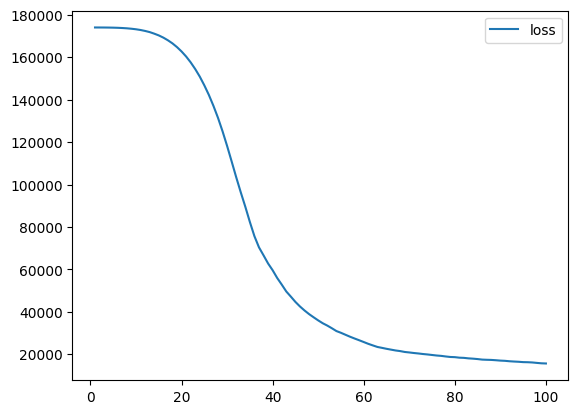

In [79]:
model_function(MIA_df, 'Miami', 7, 6, 3)

2/2 - 0s - loss: 42636.1914 - mape: 18.9250 - 107ms/epoch - 53ms/step


(<Axes: >, 42636.19140625, 18.925003051757812)

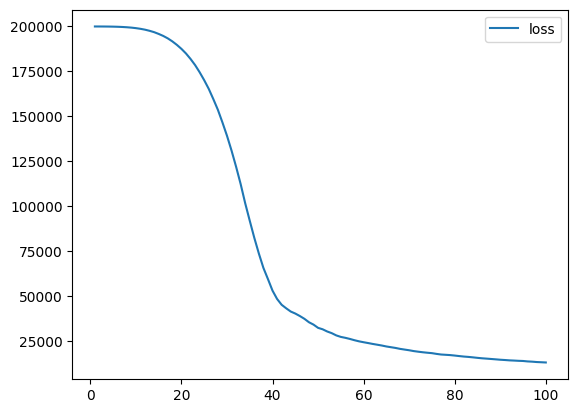

In [83]:
model_function(CHI_df, 'Chicago', 7, 6, 3)

2/2 - 0s - loss: 199575.9688 - mape: 47.0842 - 98ms/epoch - 49ms/step


(<Axes: >, 199575.96875, 47.08424758911133)

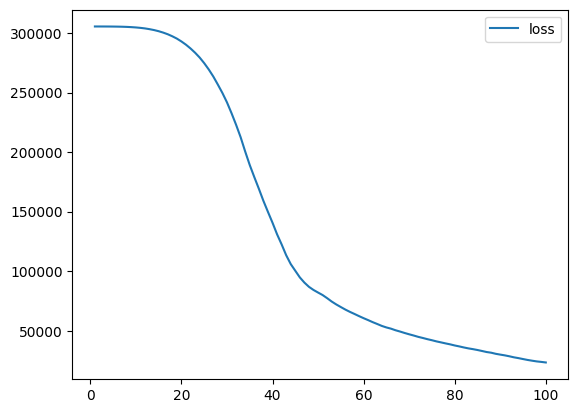

In [73]:
model_function(SEA_df, 'Seattle', 7, 6, 3)

2/2 - 0s - loss: 63027.0117 - mape: 28.6069 - 98ms/epoch - 49ms/step


(<Axes: >, 63027.01171875, 28.606914520263672)

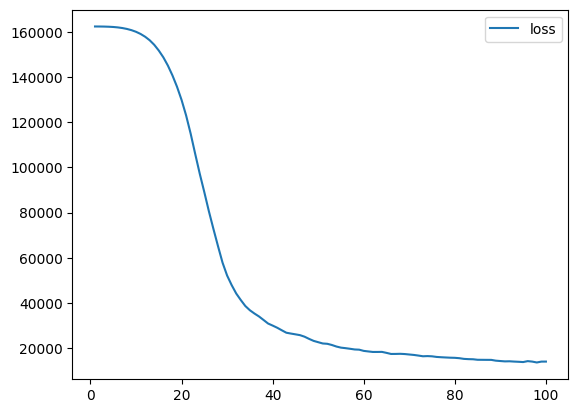

In [74]:
model_function(HOU_df, 'Houston', 7, 6, 3)

2/2 - 0s - loss: 74885.0078 - mape: 18.2508 - 101ms/epoch - 50ms/step


(<Axes: >, 74885.0078125, 18.250791549682617)

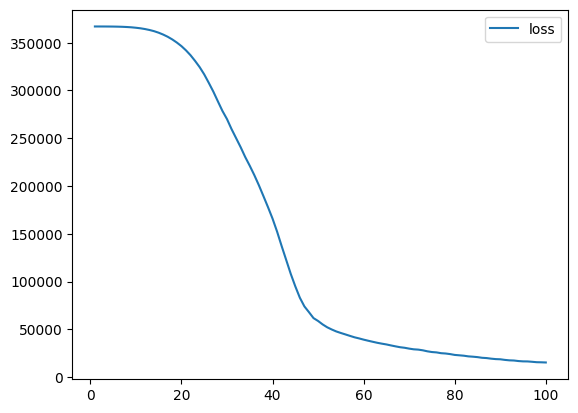

In [75]:
model_function(NYC_df, 'New York', 7, 6, 3)

2/2 - 0s - loss: 117963.3125 - mape: 42.7057 - 145ms/epoch - 72ms/step


(<Axes: >, 117963.3125, 42.705692291259766)

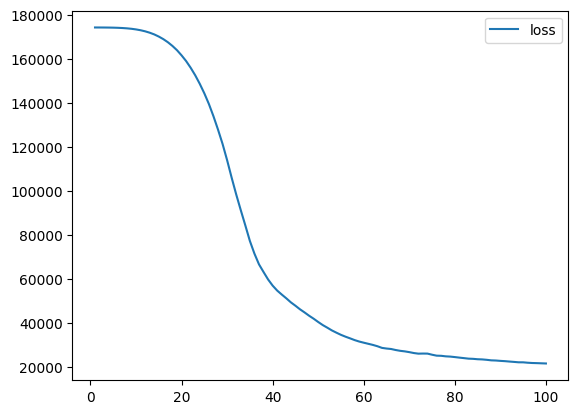

In [76]:
model_function(PHO_df, 'Phoenix', 7, 6, 3)

2/2 - 0s - loss: 157006.7812 - mape: 36.0681 - 100ms/epoch - 50ms/step


(<Axes: >, 157006.78125, 36.06807327270508)

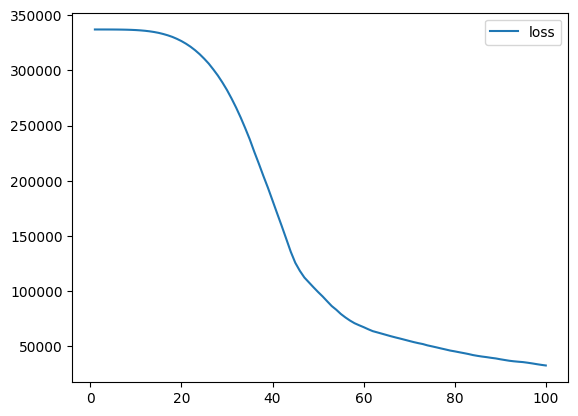

In [77]:
model_function(BOS_df, 'Boston', 7, 6, 3)

2/2 - 0s - loss: 236844.1719 - mape: 36.9203 - 104ms/epoch - 52ms/step


(<Axes: >, 236844.171875, 36.92026138305664)

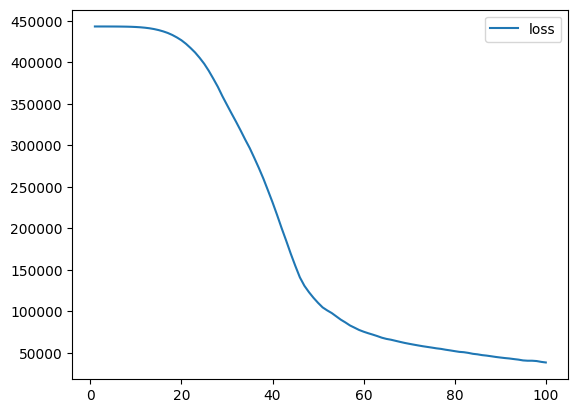

In [78]:
model_function(LAX_df, 'Los Angeles', 7, 6, 3)

In [ ]:
#try different number of nodes in hidden layers

1/1 - 0s - loss: 95578.8984 - mape: 41.8348 - 105ms/epoch - 105ms/step


(<Axes: >, 95578.8984375, 41.83477020263672)

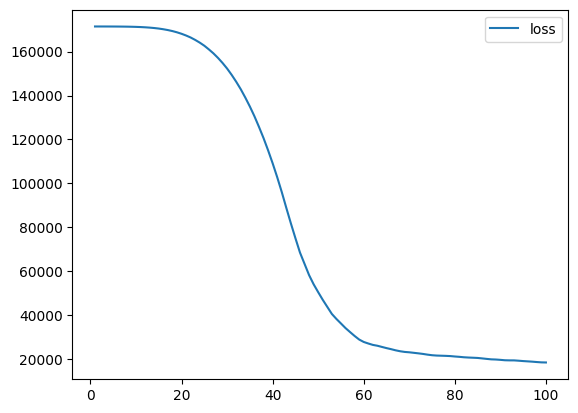

In [103]:
model_function(MIA_df, 'Miami', 7, 4, 2)

2/2 - 0s - loss: 100681.6875 - mape: 47.2392 - 100ms/epoch - 50ms/step


(<Axes: >, 100681.6875, 47.239234924316406)

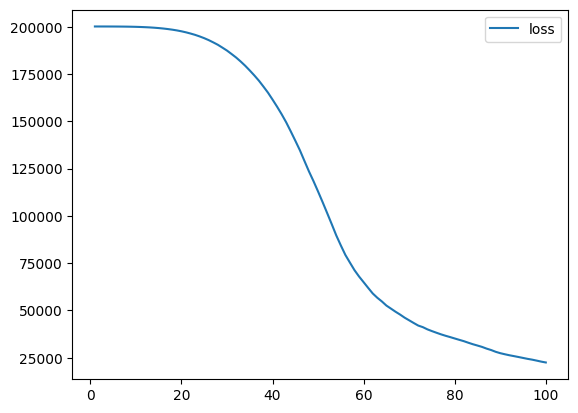

In [104]:
model_function(CHI_df, 'Chicago', 7, 4, 2)

2/2 - 0s - loss: 179403.2344 - mape: 42.1253 - 107ms/epoch - 53ms/step


(<Axes: >, 179403.234375, 42.125274658203125)

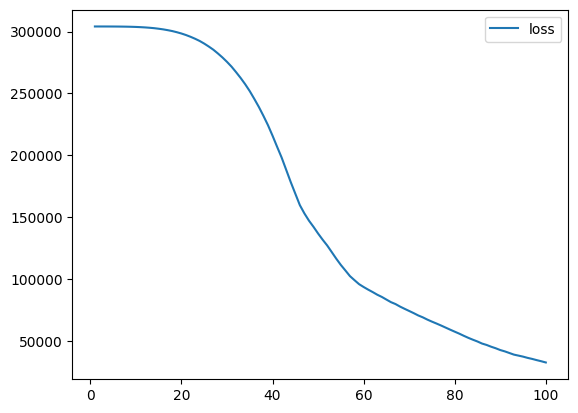

In [105]:
model_function(SEA_df, 'Seattle', 7, 4, 2)

2/2 - 0s - loss: 78605.7812 - mape: 36.1530 - 102ms/epoch - 51ms/step


(<Axes: >, 78605.78125, 36.152984619140625)

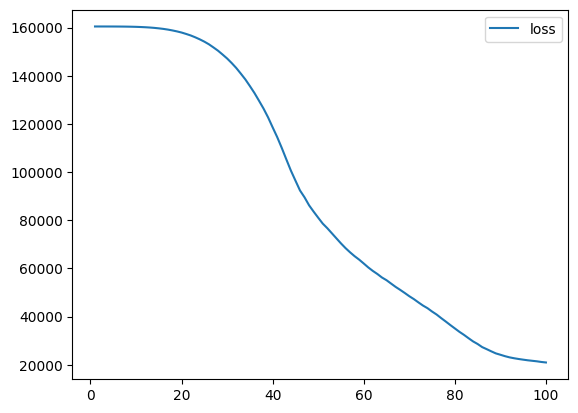

In [106]:
model_function(HOU_df, 'Houston', 7, 4, 2)

2/2 - 0s - loss: 151911.3281 - mape: 38.4197 - 95ms/epoch - 48ms/step


(<Axes: >, 151911.328125, 38.41972351074219)

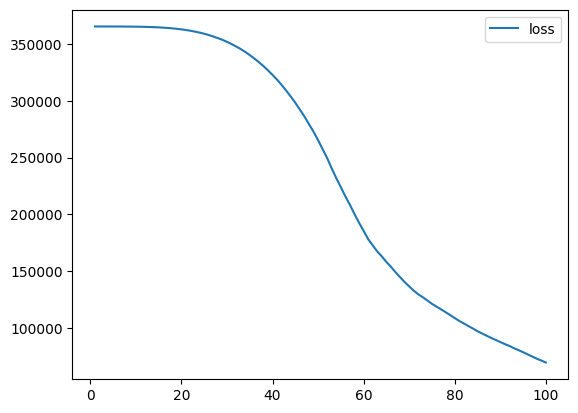

In [107]:
model_function(NYC_df, 'New York', 7, 4, 2)

2/2 - 0s - loss: 102254.4219 - mape: 37.9810 - 99ms/epoch - 49ms/step


(<Axes: >, 102254.421875, 37.98100662231445)

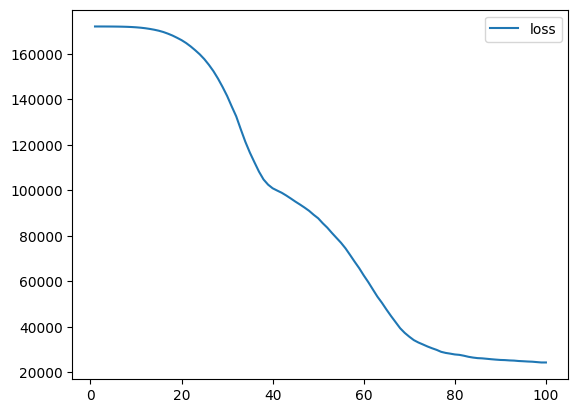

In [109]:
model_function(PHO_df, 'Phoenix', 7, 4, 2)

2/2 - 0s - loss: 286471.3438 - mape: 66.9956 - 100ms/epoch - 50ms/step


(<Axes: >, 286471.34375, 66.99559020996094)

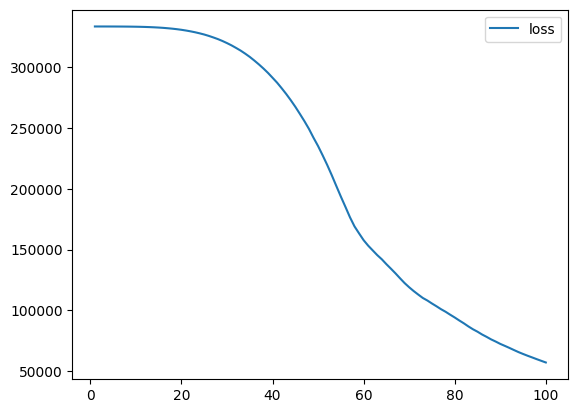

In [114]:
model_function(BOS_df, 'Boston', 7, 4, 2)

2/2 - 0s - loss: 1073306.8750 - mape: 181.3187 - 106ms/epoch - 53ms/step


(<Axes: >, 1073306.875, 181.31869506835938)

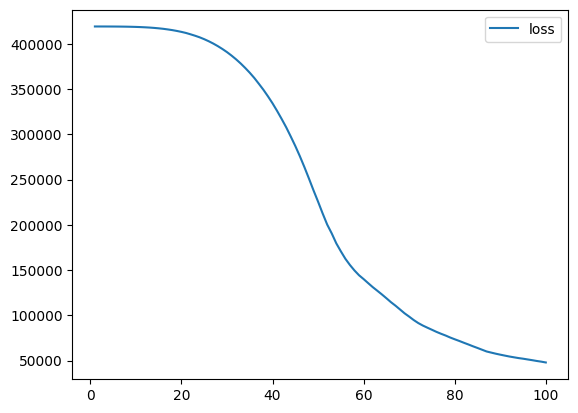

In [116]:
model_function(LAX_df, 'Los Angeles', 7, 4, 2)

In [92]:
#run a one layer NN
def one_layer_function(df, city, features, layer1):
  train_features, test_features, train_labels, test_labels = process_df(df, city)
  X_scaler = StandardScaler()

  # scaler
  X_scaler.fit(train_features)
  train_features_scaled = X_scaler.transform(train_features)
  test_features_scaled = X_scaler.transform(test_features)

#architecture
  number_input_features = features
  hidden_nodes_layer1 =  layer1
  linear_model_n = tf.keras.Sequential()
  linear_model_n.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))
  linear_model_n.add(Dense(units=1, activation="relu"))
  linear_model_n.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error', metrics=['mape'])
  model = linear_model_n.fit(train_features_scaled,
    train_labels,
    verbose=0, epochs=1000)

  #results gathering
  df = pd.DataFrame(model.history, index=range(1, len(model.history["loss"]) + 1))
  loss_figure = df.plot(y="loss")
  model_loss_n, model_mape_n = linear_model_n.evaluate(test_features_scaled, test_labels, verbose=2)
  return loss_figure, model_loss_n, model_mape_n

2/2 - 0s - loss: 298832.1250 - mape: 50.2665 - 95ms/epoch - 47ms/step


(<Axes: >, 298832.125, 50.26652145385742)

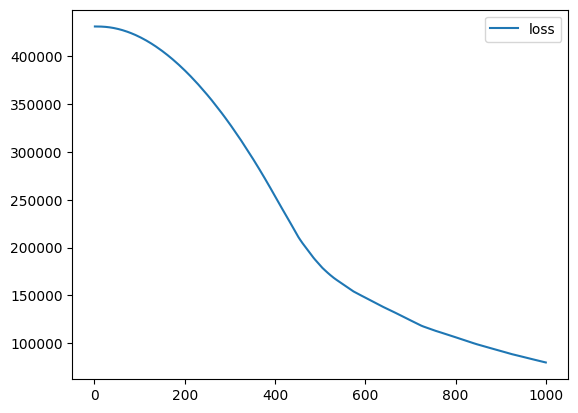

In [102]:
one_layer_function(LAX_df, 'Los Angeles', 7, 3)

2/2 - 0s - loss: 84024.1484 - mape: 39.5569 - 97ms/epoch - 49ms/step


(<Axes: >, 84024.1484375, 39.55690002441406)

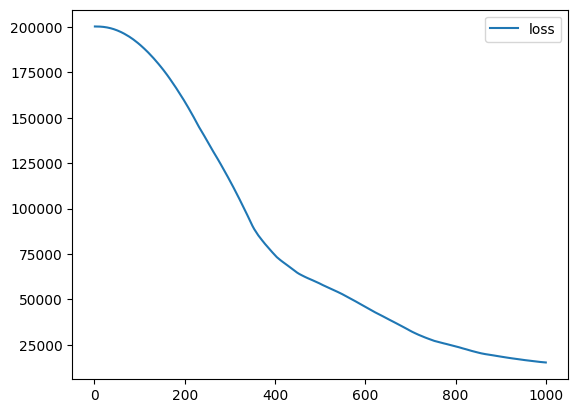

In [94]:
one_layer_function(CHI_df, 'Chicago', 7, 3)

2/2 - 0s - loss: 54766.3945 - mape: 13.5537 - 104ms/epoch - 52ms/step


(<Axes: >, 54766.39453125, 13.553656578063965)

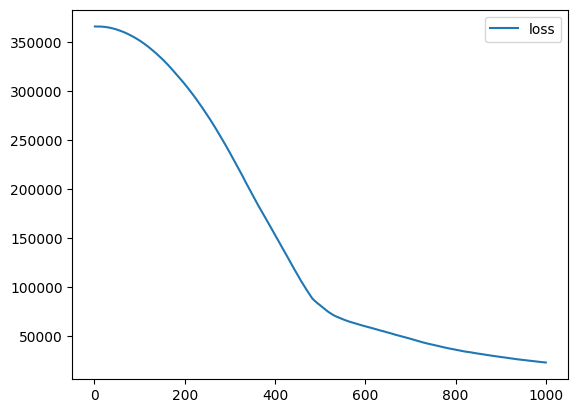

In [96]:
one_layer_function(NYC_df, 'New York', 7, 3)

2/2 - 0s - loss: 118414.5938 - mape: 27.3373 - 138ms/epoch - 69ms/step


(<Axes: >, 118414.59375, 27.33733558654785)

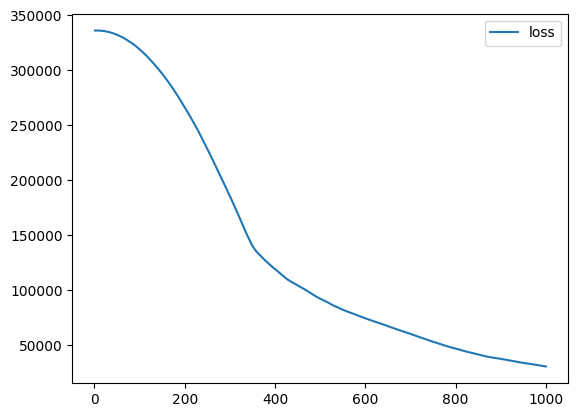

In [97]:
one_layer_function(BOS_df, 'Boston', 7, 3)

2/2 - 0s - loss: 123107.5234 - mape: 45.5187 - 97ms/epoch - 48ms/step


(<Axes: >, 123107.5234375, 45.51873016357422)

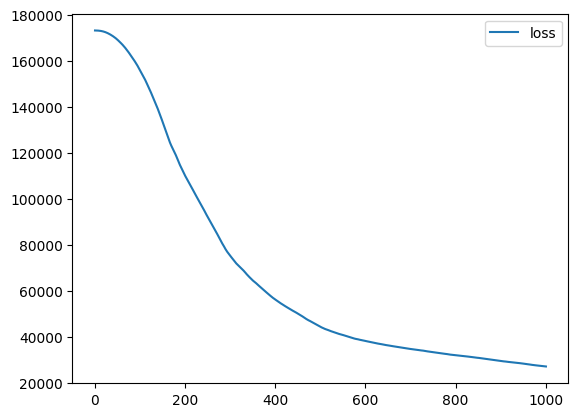

In [98]:
one_layer_function(PHO_df, 'Phoenix', 7, 3)

1/1 - 0s - loss: 69034.8281 - mape: 29.4418 - 96ms/epoch - 96ms/step


(<Axes: >, 69034.828125, 29.4417667388916)

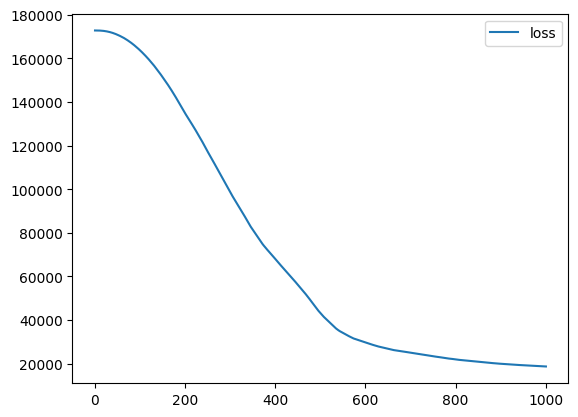

In [99]:
one_layer_function(MIA_df, 'Miami', 7, 3)

2/2 - 0s - loss: 143425.8281 - mape: 34.4247 - 127ms/epoch - 63ms/step


(<Axes: >, 143425.828125, 34.42469024658203)

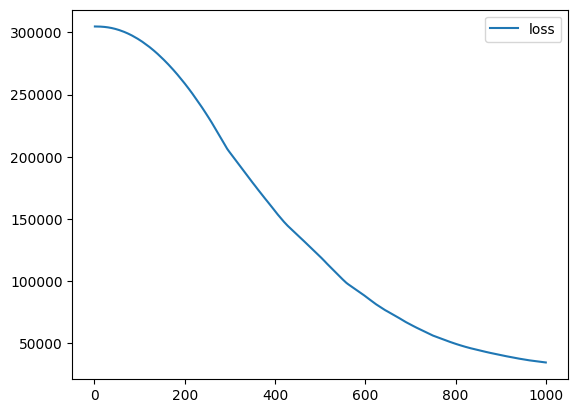

In [100]:
one_layer_function(SEA_df, 'Seattle', 7, 3)

2/2 - 0s - loss: 96448.2891 - mape: 43.7381 - 94ms/epoch - 47ms/step


(<Axes: >, 96448.2890625, 43.738059997558594)

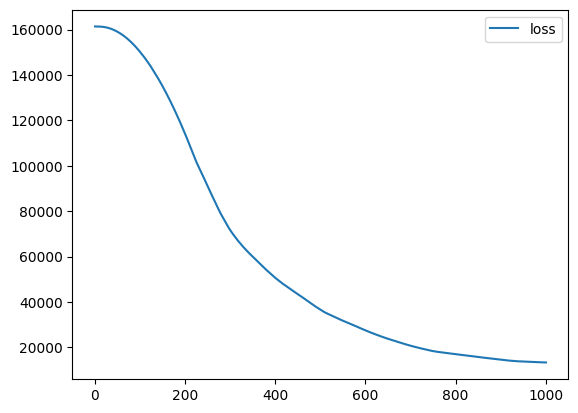

In [101]:
one_layer_function(HOU_df, 'Houston', 7, 3)

In [59]:
#package the KNN model into a function to easily scale across cities
def run_KNN(df, city):
  train_features, test_features, train_labels, test_labels = process_df(df, city)
  scaler = StandardScaler()
  train_scaled = scaler.fit_transform(train_features)
  test_scaled = scaler.transform(test_features)
  model = KNeighborsRegressor()
  model.fit(train_scaled, train_labels)
  mape = mean_absolute_percentage_error(train_labels, model.predict(train_scaled))
  mape_test = mean_absolute_percentage_error(test_labels, model.predict(test_scaled))
  return mape, mape_test

In [18]:
#run used for streamlit presentation
print(run_KNN(MIA_df, 'Miami'))
print(run_KNN(CHI_df, 'Chicago'))
print(run_KNN(SEA_df, 'Seattle'))
print(run_KNN(HOU_df, 'Houston'))
print(run_KNN(NYC_df, 'New York'))
print(run_KNN(PHO_df, 'Phoenix'))
print(run_KNN(BOS_df, 'Boston'))
print(run_KNN(MIA_df, 'Miami')) #oops
print(run_KNN(LAX_df, 'Los Angeles'))


(0.02349860601046214, 0.1441285849397165)
(0.031435961049912836, 0.0987621970403157)
(0.018147221053100026, 0.18210605847741618)
(0.02391944972274581, 0.11719752670415061)
(0.015996739125371792, 0.089619319262542)
(0.016680126949254796, 0.20371400805845946)
(0.02714432888564514, 0.1469141976089845)
(0.02439124684102116, 0.13129038404644652)
(0.014666425874001484, 0.1575981509530972)


In [68]:
#clear signs of overfitting
print(run_KNN(MIA_df, 'Miami'))
print(run_KNN(CHI_df, 'Chicago'))
print(run_KNN(SEA_df, 'Seattle'))
print(run_KNN(HOU_df, 'Houston'))
print(run_KNN(NYC_df, 'New York'))
print(run_KNN(PHO_df, 'Phoenix'))
print(run_KNN(BOS_df, 'Boston'))
print(run_KNN(LAX_df, 'Los Angeles'))

(0.020983277706076442, 0.12392855801484456)
(0.031435961049912836, 0.0987621970403157)
(0.018147221053100026, 0.18210605847741618)
(0.02391944972274581, 0.11719752670415061)
(0.015996739125371792, 0.089619319262542)
(0.016680126949254796, 0.20371400805845946)
(0.02714432888564514, 0.1469141976089845)
(0.014666425874001484, 0.1575981509530972)


In [28]:
train_features, test_features, train_labels, test_labels = process_df(LAX_df, 'Los Angeles')

In [218]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_features)
test_scaled = scaler.transform(test_features)

In [220]:
model = KNeighborsRegressor()

In [221]:
model.fit(train_scaled, train_labels)

KNeighborsRegressor()

In [223]:
mape = mean_absolute_percentage_error(train_labels, model.predict(train_scaled))

In [224]:
mape

0.023119838787071755

In [225]:
mape_test = mean_absolute_percentage_error(test_labels, model.predict(test_scaled))

In [226]:
mape_test

0.18979724077604515

In [49]:
#leaf sizes to check
leaf_size = list(range(1,50))
#number of neighbors to check
n_neighbors = list(range(1,10))
#power to check
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsRegressor()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(train_features,train_labels)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 2
Best n_neighbors: 9


In [20]:
#use GridSearch suggested parameters
def optimal_run_KNN(df, city):
  train_features, test_features, train_labels, test_labels = process_df(df, city)
  scaler = StandardScaler()
  train_scaled = scaler.fit_transform(train_features)
  test_scaled = scaler.transform(test_features)
  model = KNeighborsRegressor(n_neighbors=9, leaf_size=1)
  model.fit(train_scaled, train_labels)
  mape = mean_absolute_percentage_error(train_labels, model.predict(train_scaled))
  mape_test = mean_absolute_percentage_error(test_labels, model.predict(test_scaled))
  return mape, mape_test

In [61]:
#MAPE for each city... again obvious signs of overfitting
print(optimal_run_KNN(LAX_df, 'Los Angeles'))
print(optimal_run_KNN(CHI_df, 'Chicago'))
print(optimal_run_KNN(NYC_df, 'New York'))
print(optimal_run_KNN(MIA_df, 'Miami'))
print(optimal_run_KNN(BOS_df, 'Boston'))
print(optimal_run_KNN(HOU_df, 'Houston'))
print(optimal_run_KNN(PHO_df, 'Phoenix'))
print(optimal_run_KNN(SEA_df, 'Seattle'))

(0.07297919206787665, 0.2378189673874254)
(0.0556962758565225, 0.10455297478003538)
(0.02463584355561205, 0.07838136797210048)
(0.09843262335244696, 0.2674559050828131)
(0.05592885649699317, 0.21771313856072616)
(0.0944064187793486, 0.2724948557122724)
(0.10194841476670265, 0.3257640257796053)
(0.05048753206961867, 0.28223274278101873)


In [62]:
knn_initial = [22.1728, 08.5710, 22.068, 22.8320, 06.325, 30.5834, 16.4761, 21.43]
knn_optimal = [23.732, 09.737, 22.3877, 23.8622, 06.11, 31.5044, 17.2854, 18.9200]
new_list = [a_i - b_i for a_i, b_i in zip(knn_initial, knn_optimal)]

In [63]:
sum(new_list)

-3.080400000000001

In [ ]:
### Run model on entire history for each city

In [64]:
#helper function to process data
def process_nosplit_df(df, city_name):
  df[city_name] = df[city_name].shift(3)
  df = df.dropna()
  features = df

  labels = df.pop(city_name)
  return features, labels

In [65]:
#new KNN run for which the entire data set is used and there is no split
def optimal_whole_run_KNN(df, city):
  features, labels = process_nosplit_df(df, city)
  scaler = StandardScaler()
  features_scaled = scaler.fit_transform(features)
  model = KNeighborsRegressor(n_neighbors=9, leaf_size=1)
  model.fit(features_scaled, labels)
  mape = mean_absolute_percentage_error(labels, model.predict(features_scaled))
  return mape

In [71]:
#MAPE for model on each city
print(optimal_whole_run_KNN(LAX_df, 'Los Angeles'))
print(optimal_whole_run_KNN(CHI_df, 'Chicago'))
print(optimal_whole_run_KNN(MIA_df, 'Miami'))
print(optimal_whole_run_KNN(PHO_df, 'Phoenix'))
print(optimal_whole_run_KNN(BOS_df, 'Boston'))
print(optimal_whole_run_KNN(SEA_df, 'Seattle'))
print(optimal_whole_run_KNN(NYC_df, 'New York'))
print(optimal_whole_run_KNN(HOU_df, 'Houston'))

0.023239209644184272
0.042178429598528674
0.03452999551656116
0.03229712890951905
0.033636331441685326
0.031371718502928796
0.023337587902022602
0.02864134055766307
